In [2]:
import numpy as np
from cvxopt import solvers, matrix, spmatrix, spdiag, sparse
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from softsvm import softsvm, fix_small_eigvals, error, get_random_sample
import softsvm

data = np.load('ex2q4_data.npz')
trainX, testX = data['Xtrain'], data['Xtest']
trainY, testY = data['Ytrain'], data['Ytest']

In [3]:
def K(xi, xj, k):
    """
    :param xi, xj: two vectors of the same dimension
    :param k: the degree of the poly kernel
    :return: (1 + dot_res)^k
    """
    # sanity check
    assert xi.shape == xj.shape, "xi and xj should be of the same shape\ngot xi.shape = {}, xj.shape = {}".format(xi.shape, xj.shape)
    return np.power(np.dot(xi, xj) + 1.0, k)

In [4]:
def get_gram_matrix(X, k):
    G = np.dot(X, X.T)
    # apply k to every item in G
    G = np.vectorize(lambda x: np.power(x, k))(G)
    return G
    

In [5]:
def softsvmpoly(l: float, k: float, trainX: np.array, trainy: np.array):
    """
    :param l: the parameter lambda of the soft SVM algorithm
    :param sigma: the bandwidth parameter sigma of the RBF kernel.
    :param trainX: numpy array of size (m, d) containing the training sample
    :param trainy: numpy array of size (m, 1) containing the labels of the training sample
    :return: numpy array of size (m, 1) which describes the coefficients found by the algorithm
    """
    m, d = trainX.shape
    
    G = get_gram_matrix(trainX, k)

    H = np.pad(float(2 * l) * G, [(0, m), (0, m)])
    H = fix_small_eigvals(H)

    A = np.block([[np.zeros((m, m)), np.identity(m)],
                  [G * trainy.reshape(-1, 1), np.identity(m)]])

    u = np.hstack((np.full(m, float(0)), np.full(m, 1/m)))

    v = np.hstack((np.zeros(m), np.ones(m)))
  
    z = solvers.qp(matrix(H), matrix(u), -matrix(A), -matrix(v))
    alphas = np.array(z["x"])[:m]
    return alphas

In [6]:
def cartesian_product(set_a: np.array, set_b: np.array):
    return [(ai, bi) for ai in set_a for bi in set_b]

In [7]:
def predict_single_sample(alphas: np.array, k: int, sample: np.array, trainX: np.array):
    train_kernels = np.array([K(sample, xi, k) for xi in trainX])
    return np.sign(np.dot(train_kernels, alphas))


In [8]:
def predict(alphas: np.array, k: int, testX: np.array, trainX: np.array):
    """
    :param alphas: numpy array of size (m, 1) containing the coefficients of the soft SVM algorithm
    :param testX: numpy array of size (m, d) containing the test sample
    :param k: int, the degree of the poly kernel
    :return: numpy array of size (m, 1) containing the predicted labels of the test sample
    """
    
    return np.array([predict_single_sample(alphas, k, sample, trainX) for sample in testX])

In [9]:
def split_data(folds: int):
    X_chunks = np.array(np.split(trainX, folds))
    Y_chunks = np.array(np.split(trainY, folds))
    splitted = []
    shp = X_chunks.shape
    for i in range(folds):
        test, test_labales = X_chunks[i], Y_chunks[i]
        # current test set is the the entire train besides the current chunk used for training
        train = np.concatenate(np.delete(X_chunks, i, axis=0))
        train_labales = np.concatenate(np.delete(Y_chunks, i, axis=0))
        splitted.append({"train": train,
                        "train_labales": train_labales,
                        "test": test,
                        "test_labales": test_labales})
    return np.array(splitted)

In [10]:
def poly_cross_validation(lambdas: np.array, ks, folds: int):
    """
    find pair (lambda, k) with the lowest validation error, and get classifier based on that pair
    :param lambdas: the lambda parameters to use
    :param ks: the k parameters to use in the kernel function
    :param folds: number of chunks we split the data to
    :return: prediction of test set of classifier trained on the entire train set using best lambda and k found
    """
    # poly softSVM
    errors = {(l, k): 0 for l, k in cartesian_product(lambdas, ks)}
    a = split_data(folds)
    for fold in split_data(folds):
        for l, k in cartesian_product(lambdas, ks):
            print(l,k)
            alphas = softsvmpoly(l, k, fold["train"], fold["train_labales"])
            predicted = predict(alphas, k, fold["test"], fold["train"])
            # continuesly calculate the avg error
            errors[(l, k)] += error(fold["test_labales"], predicted) / folds
    
    # get the pair with lowest avg error
    best_lambda, best_k = min(errors.items(), key=lambda x: x[1])[0]
    print(f"best_lambda={best_lambda}, best_k={best_k}")
    alphas = softsvmpoly(best_lambda, best_k, trainX, trainY)
    return predict(alphas, best_k, testX, trainX)

In [11]:
def softsvm_cross_validation(lambdas, folds):
    errors = {l: 0 for l in lambdas}
    for fold in split_data(folds):
        for l in lambdas:
            w = softsvm.softsvm(l, fold["train"], fold["train_labales"])
            errors[l] += error(fold["test_labales"], softsvm.predict(w, fold["test"])) / folds
    
    # get the l with lowest avg error
    best_lambda = min(errors.items(), key=lambda x: x[1])[0]
    print(f"best_lambda={best_lambda}")
    w = softsvm.softsvm(best_lambda, trainX, trainY)
    return softsvm.predict(w, testX)

In [12]:
def cross_validation_error():
    lambdas = np.array([1.0, 10.0, 100.0])
    ks = np.array([2.0, 5.0, 8.0])
    k_folds = 5
    # polynomial kernel
    poly_predicions = poly_cross_validation(lambdas, ks, folds=k_folds)
    poly_error = error(testY, poly_predicions)
    # best_lambda=10.0, best_k=5.0

    # linear softsvm
    soft_svm_predictions = softsvm_cross_validation(lambdas, folds=k_folds)
    soft_svm_error =  error(testY, soft_svm_predictions)
    # best_lambda=1.0

    print(f"soft_svm_error={soft_svm_error}")
    print(f"poly_error={poly_error}")


     pcost       dcost       gap    pres   dres
 0:  2.6636e+01  3.9127e+02  6e+03  2e+00  1e+04
 1:  5.5017e+00 -3.8988e+02  4e+02  2e-01  8e+02
 2:  4.7000e+00 -1.1880e+00  6e+00  6e-04  2e+00
 3:  1.8941e+00  1.2443e+00  6e-01  4e-16  2e-14
 4:  1.5046e+00  1.4859e+00  2e-02  2e-16  1e-14
 5:  1.4989e+00  1.4987e+00  2e-04  2e-16  1e-14
 6:  1.4989e+00  1.4989e+00  2e-06  2e-16  1e-14
 7:  1.4989e+00  1.4989e+00  2e-08  2e-16  1e-14
Optimal solution found.


KeyboardInterrupt: 

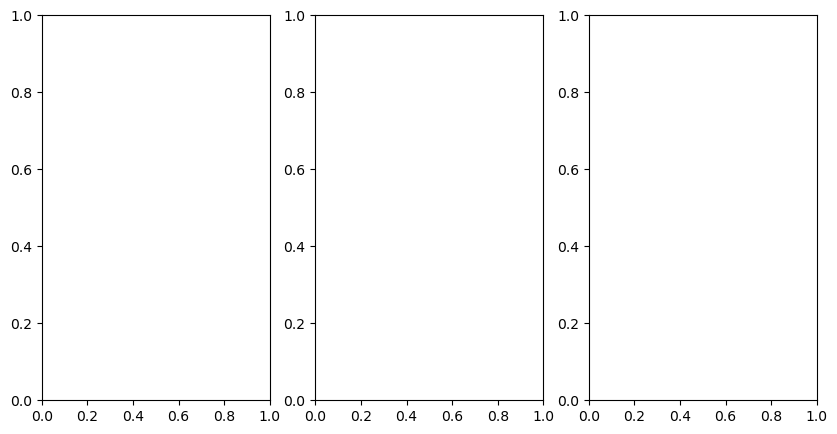

In [25]:
def Q4_e():
    def plot_predictor(l, k, alphas, ax):
        step_size = 0.1
        x = np.arange(trainX[:, 0].min(), trainX[:, 0].max(), step_size)
        y = np.arange(trainX[:, 1].min(), trainX[:, 1].max(), step_size)

        grid = [[predict_single_sample(alphas, k, np.array([xi, yi]), trainX) for xi in x] for yi in reversed(y)]   
        ax.imshow(grid, cmap='coolwarm', extent=[-1, 1, 1, -1])
        ax.set_title(f"λ={l} k={k}")

    l = 100.0
    ks = np.array([3.0, 5.0, 8.0])

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    for ax, k in zip(axs, ks):
        alphas = softsvmpoly(l, k, trainX, trainY)
        plot_predictor(l ,k, alphas, ax)
    plt.savefig("Q4_e.png")
    plt.show()

Q4_e()